In [1]:
import tensorflow as tf 
import numpy as np 
#from PatternRecognition import *

In [4]:
def symmetric_cross_entropy(alpha, beta):
    def loss(y_true, y_pred):
        y_true_1 = y_true
        y_pred_1 = y_pred

        y_true_2 = y_true
        y_pred_2 = y_pred

        y_pred_1 = tf.clip_by_value(y_pred_1, 1e-7, 1.0)
        y_true_2 = tf.clip_by_value(y_true_2, 1e-4, 1.0)

        return alpha*tf.reduce_mean(-tf.reduce_sum(y_true_1 * tf.math.log(y_pred_1), axis = -1)) + beta*tf.reduce_mean(-tf.reduce_sum(y_pred_2 * tf.math.log(y_true_2), axis = -1))
    return loss

In [3]:
from keras.datasets import mnist
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
from sklearn.metrics import accuracy_score
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(123)

class MNISTClassificationBaseModel(ABC):

  class_count = 10
  original_dataset_shape = (28, 28)
  classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

  @abstractmethod
  def __init__(self, balanced=False, noise_type='No Noise', noise_ratio=0):
    (self._x_train, self._y_train), (self._x_test, self._y_test) = mnist.load_data()
    self._original_dataset = (np.copy(self._x_train), np.copy(self._y_train),
                              np.copy(self._x_test), np.copy(self._y_test))

    if balanced is True:
      self.balance_dataset()

    self.shape_data()
    
    if noise_type == 'asym':
      self.induce_asym_noise(noise_ratio)
      clean_selected = np.argwhere(self.get_training_label() == self.get_original_dataset()[1]).reshape((-1,))
      noisy_selected = np.argwhere(self.get_training_label() != self.get_original_dataset()[1]).reshape((-1,))
      print("#correct labels: %s, #incorrect labels: %s" % (len(clean_selected), len(noisy_selected)))
    elif noise_type == 'sym':
      self.induce_sym_noise(noise_ratio)
      clean_selected = np.argwhere(self.get_training_label() == self.get_original_dataset()[1]).reshape((-1,))
      noisy_selected = np.argwhere(self.get_training_label() != self.get_original_dataset()[1]).reshape((-1,))
      print("#correct labels: %s, #incorrect labels: %s" % (len(clean_selected), len(noisy_selected)))
    elif noise_type == 'No Noise':
      pass
    else:
      raise ValueError('%s noise type is not recognized. Value can be asym, sym or No Noise' % noise_type)

  def get_original_dataset(self):
    return self._original_dataset;

  def get_training_image(self):
    return self._x_train

  def get_training_label(self):
    return self._y_train

  def get_test_image(self):
    return self._x_test

  def get_test_label(self):
    return self._y_test

  def scale_pixels(self):
    # Convert from integers to float
    self._x_train = self._x_train.astype('float32')
    self._x_test = self._x_test.astype('float32')

    # Normalize pixels from range [0, 255] to [0, 1]
    self._x_train /= 255.0
    self._x_test /= 255.0

  def show_class_distribution(self, original_dataset=False):
    if original_dataset:
      unique, counts = np.unique(self.get_original_dataset()[1], return_counts=True)
      plt.bar(unique, counts)
      # unique, counts = np.unique(self.get_original_dataset()[3], return_counts=True)
      # plt.bar(unique, counts)
    else:
      unique, counts = np.unique(self.get_training_label(), return_counts=True)
      plt.bar(unique, counts)
      # unique, counts = np.unique(self.get_test_label(), return_counts=True)
      # plt.bar(unique, counts)

    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

    plt.show()

  def print_accuracy(self, predicted):
    print('Accuracy for the predicted labels : ' , accuracy_score(self.get_test_label(), predicted) * 100)

  def display_confusion_matrix(self, predicted):
    cm = metrics.confusion_matrix(self.get_test_label(), predicted,
                                  labels=MNISTClassificationBaseModel.classes)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                          display_labels=MNISTClassificationBaseModel.classes)
    disp.plot()
    plt.show()

  def display_samples(self, images, actual_labels, predicted_labels, is_label_pre_processed):

    images = images.reshape(*self.get_model_shape())
    predicted_labels = predicted_labels.squeeze()
    actual_labels = actual_labels.squeeze()

    l = len(images)

    while True:
      if l <= 0:
        break

      cols = min(5, l)

      subset_images, images = np.asarray(images[:cols]), np.asarray(images[cols:])
      subset_predicted_labels, predicted_labels = np.asarray(predicted_labels[:cols]), np.asarray(predicted_labels[cols:])
      subset_actual_labels, actual_labels = np.asarray(actual_labels[:cols]), np.asarray(actual_labels[cols:])

      _, axes = plt.subplots(nrows=1, ncols=cols, figsize=(10, 3),
                          constrained_layout=True)

      for ax, image, actual_label, predicted_label in zip(axes, subset_images, subset_actual_labels, subset_predicted_labels):
        ax.set_axis_off()
        ax.imshow(image.reshape(MNISTClassificationBaseModel.original_dataset_shape), cmap='gray')
        if is_label_pre_processed:
          ax.set_title('Actual: %i, Predicted: %i' % (np.argmax(actual_label), np.argmax(predicted_label)))
        else:
          ax.set_title('Actual: %i, Predicted: %i' % (actual_label, predicted_label))

      plt.show()

      l -=cols

  def _get_misclassified_indices(self, predicted):
    return np.nonzero(predicted != self.get_test_label())

  def get_misclassified(self, predicted):
    misclassified_indices = np.asarray(self._get_misclassified_indices(predicted))
    misclassified_test_image = self.get_test_image()[misclassified_indices]
    misclassified_predicted_label = predicted[misclassified_indices]
    misclassified_actual_label = self.get_test_label()[misclassified_indices]
    return misclassified_test_image, misclassified_actual_label, misclassified_predicted_label

  def balance_dataset(self):
    rus = RandomUnderSampler(random_state=123)
    self._x_train, self._y_train = rus.fit_resample(self.get_training_image(), self.get_training_label())

  def induce_asym_noise(self, noise_ratio=40):
    source_class = [7, 2, 3, 5, 6]
    target_class = [1, 7, 8, 6, 5]
    y_train_clean = np.copy(self.get_training_label())

    for s, t in zip(source_class, target_class):
      cls_idx = np.where(y_train_clean == s)[0]
      # print('cls_idx',cls_idx)
      n_noisy = int(noise_ratio * cls_idx.shape[0] / 100)
      # print('n_noisy',n_noisy)
      noisy_sample_index = np.random.choice(cls_idx, n_noisy, replace=False)
      # print(noisy_sample_index)
      self._y_train[noisy_sample_index] = t

    print("Print noisy label generation statistics:")
    for i in range(MNISTClassificationBaseModel.class_count):
      n_noisy = np.sum(self.get_training_label() == i)
      print("Noisy class %s, has %s samples." % (i, n_noisy))

  def other_class(self, n_classes, current_class):
    if current_class < 0 or current_class >= n_classes:
        error_str = "class_ind must be within the range (0, nb_classes - 1)"
        raise ValueError(error_str)

    other_class_list = list(range(n_classes))
    other_class_list.remove(current_class)
    other_class = np.random.choice(other_class_list)
    return other_class

  def induce_sym_noise(self, noise_ratio=40):
    y_train_clean = np.copy(self.get_training_label())
    n_samples = self.get_training_label().shape[0]
    n_noisy = int(noise_ratio * n_samples / 100)
    # print(n_samples, n_noisy)
    class_index = [np.where(y_train_clean == i)[0] for i in range(MNISTClassificationBaseModel.class_count)]
    class_noisy = int(n_noisy / 10)

    noisy_idx = []
    for d in range(MNISTClassificationBaseModel.class_count):
      noisy_class_index = np.random.choice(class_index[d], class_noisy, replace=False)
      noisy_idx.extend(noisy_class_index)

    for i in noisy_idx:
      self._y_train[i] = self.other_class(n_classes=MNISTClassificationBaseModel.class_count,
                                     current_class=self.get_training_label()[i])

  @abstractmethod
  def shape_data(self):
    pass

  @abstractmethod
  def get_model_shape(self):
    pass

  @abstractmethod
  def pre_process_label(self):
    pass

  @abstractmethod
  def _define_model(self):
    pass


In [5]:
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from keras.utils import np_utils

class SLModel(MNISTClassificationBaseModel):

  shape = (-1, 28, 28, 1)

  def __init__(self, balanced=False, noise_type='No Noise', noise_ratio=0):
    # Call the parent constructor to load the mninst dataset
    super().__init__(balanced, noise_type, noise_ratio)
  
  def balance_dataset(self):
    
    rus = RandomUnderSampler(random_state=123)
    self._x_train = self._x_train.reshape(-1, 28 * 28)
    print(self._x_train.shape)
    self._x_train, self._y_train = rus.fit_resample(self.get_training_image(), self.get_training_label())
    #print(self._x_train.shape)

  def get_model_shape(self):
    return SLModel.shape

  def shape_data(self):
    self._x_train = self._x_train.reshape(*SLModel.shape)
    self._x_test = self._x_test.reshape(*SLModel.shape)
    self.scale_pixels()

  def pre_process_label(self):
    self._y_train = np_utils.to_categorical(self._y_train, 10)
    self._y_test = np_utils.to_categorical(self._y_test, 10)

  def display_confusion_matrix(self, predicted):
    cm = metrics.confusion_matrix(np.argmax(self.get_test_label(), axis=1), predicted,
                                  labels=MNISTClassificationBaseModel.classes)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                          display_labels=MNISTClassificationBaseModel.classes)
    disp.plot()
    plt.show()

  def _define_model(self):
    image_shape =self. _x_train.shape[1:]
    img_input = Input(shape=image_shape)

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal", name='conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal", name='conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    x = Flatten()(x)

    x = Dense(128, kernel_initializer="he_normal", name='fc1')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid', name='lid')(x)
    # x = Dropout(0.2)(x)

    x = Dense(10, kernel_initializer="he_normal")(x)
    x = Activation(tf.nn.softmax)(x)

    model = Model(img_input, x)
    return model

  def definemodel(self):
    image_shape =self. _x_train.shape[1:]
    img_input = Input(shape=image_shape)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal", name='conv1',kernel_regularizer='l1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer="he_normal", name='conv2',kernel_regularizer='l2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    x = Flatten()(x)

    x = Dense(128, kernel_initializer="he_normal", name='fc1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='lid')(x)
    x = Dropout(0.2)(x)

    x = Dense(10, kernel_initializer="he_normal")(x)
    x = Activation(tf.nn.softmax)(x)

    model = Model(img_input, x)
    return model


  def train_and_predict(self):
    model = self._define_model()
    # Learn the digits on the train subset
    loss = symmetric_cross_entropy(1.0, 1.0)
    optimizer = SGD(lr=0.1, decay=1e-4, momentum=0.9)
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['accuracy']
    )
    datagen = ImageDataGenerator()
    #print(self.get_training_image())
    #clf=model.fit(self.get_training_image(), self.get_training_label())
    model.fit_generator(datagen.flow(self.get_training_image(),self.get_training_label(), batch_size=500),
                        steps_per_epoch=len(self.get_training_image()) / 500, epochs=5)
    # Predict the value of the digit on the test subset
    predicted = model.predict(self.get_test_image())

    return model,predicted
  
  def trainandpredict(self):
    model = self.definemodel()
    # Learn the digits on the train subset
    loss = symmetric_cross_entropy(1.0, 1.0)
    optimizer = SGD(lr=0.1, decay=1e-4, momentum=0.9)
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['accuracy']
    )
    datagen = ImageDataGenerator()
    #print(self.get_training_image())
    #clf=model.fit(self.get_training_image(), self.get_training_label())
    model.fit_generator(datagen.flow(self.get_training_image(),self.get_training_label(), batch_size=700),
                        steps_per_epoch=len(self.get_training_image()) / 700, epochs=5)
    # Predict the value of the digit on the test subset
    predicted = model.predict(self.get_test_image())

    return model,predicted


In [6]:
def symmetric_cross_entropy(alpha, beta):
    def loss(y_true, y_pred):
        y_true_1 = y_true
        y_pred_1 = y_pred

        y_true_2 = y_true
        y_pred_2 = y_pred

        y_pred_1 = tf.clip_by_value(y_pred_1, 1e-7, 1.0)
        y_true_2 = tf.clip_by_value(y_true_2, 1e-4, 1.0)

        return alpha*tf.reduce_mean(-tf.reduce_sum(y_true_1 * tf.math.log(y_pred_1), axis = -1)) + beta*tf.reduce_mean(-tf.reduce_sum(y_pred_2 * tf.math.log(y_true_2), axis = -1))
    return loss

In [7]:
print("Imabalnced and No noise")
sl_imbalanced = SLModel(balanced=False, noise_type='No Noise', noise_ratio=0)
sl_imbalanced.pre_process_label()
model,predicted = sl_imbalanced.train_and_predict()

Imabalnced and No noise


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
120/120 [==============================] - 159s 1s/step - loss: 1.0038 - accuracy: 0.9438
Epoch 2/5
120/120 [==============================] - 153s 1s/step - loss: 0.2095 - accuracy: 0.9873
Epoch 3/5
120/120 [==============================] - 152s 1s/step - loss: 0.1513 - accuracy: 0.9908
Epoch 4/5
120/120 [==============================] - 154s 1s/step - loss: 0.1144 - accuracy: 0.9933
Epoch 5/5
120/120 [==============================] - 151s 1s/step - loss: 0.0871 - accuracy: 0.9954


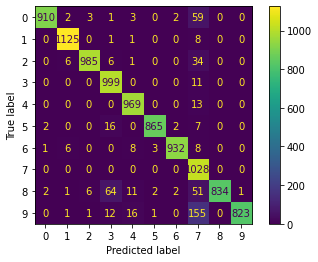

Imbalanced with No noise
Classification report for classifier <keras.engine.functional.Functional object at 0x7f892070fb10>:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.95      0.97      1032
           3       0.91      0.99      0.95      1010
           4       0.96      0.99      0.97       982
           5       0.99      0.97      0.98       892
           6       0.99      0.97      0.98       958
           7       0.75      1.00      0.86      1028
           8       1.00      0.86      0.92       974
           9       1.00      0.82      0.90      1009

    accuracy                           0.95     10000
   macro avg       0.96      0.95      0.95     10000
weighted avg       0.96      0.95      0.95     10000




In [8]:
#x, y, z = sl_imbalanced.get_misclassified(np.argmax(predicted, axis=1))


sl_imbalanced.display_confusion_matrix(np.argmax(predicted, axis=1))
print("Imbalanced with No noise")
print(f"Classification report for classifier {model}:\n"
    f"{metrics.classification_report(np.argmax(sl_imbalanced.get_test_label(),axis=1), np.argmax(predicted, axis=1))}\n")
#print(sl_imbalanced._get_misclassified_indices(np.argmax(predicted, axis=1)))

#sl_imbalanced.display_samples(x, y, z, True)

Imbalanced with Symmetrical Noise
#correct labels: 48000, #incorrect labels: 12000
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


120/120 [==============================] - 159s 1s/step - loss: 4.2766 - accuracy: 0.7481
Epoch 2/5
120/120 [==============================] - 160s 1s/step - loss: 3.6300 - accuracy: 0.7877
Epoch 3/5
120/120 [==============================] - 159s 1s/step - loss: 3.5470 - accuracy: 0.7913
Epoch 4/5
120/120 [==============================] - 158s 1s/step - loss: 3.4901 - accuracy: 0.7932
Epoch 5/5
120/120 [==============================] - 156s 1s/step - loss: 3.4459 - accuracy: 0.7950


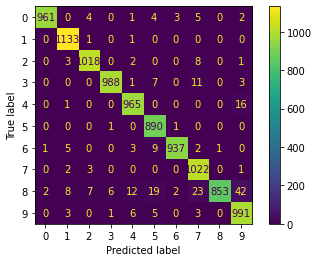

Imbalanced with Symmetric Noise
Classification report for classifier <keras.engine.functional.Functional object at 0x7fb456871050>:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.98      0.99      1010
           4       0.97      0.98      0.98       982
           5       0.95      1.00      0.97       892
           6       0.99      0.98      0.99       958
           7       0.95      0.99      0.97      1028
           8       1.00      0.88      0.93       974
           9       0.94      0.98      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000




In [10]:
print('Imbalanced with Symmetrical Noise')
sl_imbalanced1 = SLModel(balanced=False, noise_type='sym', noise_ratio=20)
sl_imbalanced1.pre_process_label()
model1,predicted1 = sl_imbalanced1.train_and_predict()
sl_imbalanced1.display_confusion_matrix(np.argmax(predicted1, axis=1))
print("Imbalanced with Symmetric Noise")
print(f"Classification report for classifier {model1}:\n"
    f"{metrics.classification_report(np.argmax(sl_imbalanced1.get_test_label(),axis=1), np.argmax(predicted1, axis=1))}\n")

Imbalanced with Asymmetrical Noise
Print noisy label generation statistics:
Noisy class 0, has 5923 samples.
Noisy class 1, has 9248 samples.
Noisy class 2, has 3575 samples.
Noisy class 3, has 3679 samples.
Noisy class 4, has 5842 samples.
Noisy class 5, has 5620 samples.
Noisy class 6, has 5719 samples.
Noisy class 7, has 6142 samples.
Noisy class 8, has 8303 samples.
Noisy class 9, has 5949 samples.
#correct labels: 48124, #incorrect labels: 11876


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
120/120 [==============================] - 162s 1s/step - loss: 3.3830 - accuracy: 0.7419
Epoch 2/5
120/120 [==============================] - 156s 1s/step - loss: 2.7082 - accuracy: 0.7824
Epoch 3/5
120/120 [==============================] - 157s 1s/step - loss: 2.6248 - accuracy: 0.7874
Epoch 4/5
120/120 [==============================] - 155s 1s/step - loss: 2.5481 - accuracy: 0.7939
Epoch 5/5
120/120 [==============================] - 153s 1s/step - loss: 2.5295 - accuracy: 0.7950


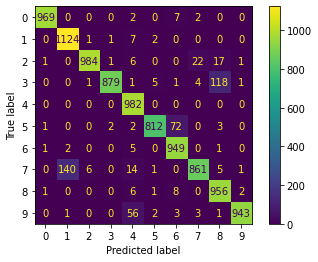

Imbalanced with Asymmetrical Noise
Classification report for classifier <keras.engine.functional.Functional object at 0x7fb455672050>:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       0.89      0.99      0.94      1135
           2       0.99      0.95      0.97      1032
           3       1.00      0.87      0.93      1010
           4       0.91      1.00      0.95       982
           5       0.99      0.91      0.95       892
           6       0.91      0.99      0.95       958
           7       0.97      0.84      0.90      1028
           8       0.87      0.98      0.92       974
           9       0.99      0.93      0.96      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000




In [11]:
print('Imbalanced with Asymmetrical Noise')
sl_imbalanced2 = SLModel(balanced=False, noise_type='asym', noise_ratio=40)
sl_imbalanced2.pre_process_label()
model2,predicted2 = sl_imbalanced2.train_and_predict()
sl_imbalanced2.display_confusion_matrix(np.argmax(predicted2, axis=1))
print('Imbalanced with Asymmetrical Noise')
print(f"Classification report for classifier {model2}:\n"
    f"{metrics.classification_report(np.argmax(sl_imbalanced2.get_test_label(),axis=1), np.argmax(predicted2, axis=1))}\n")

Balanced with Symmetrical Noise
(60000, 784)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


#correct labels: 0, #incorrect labels: 0
Epoch 1/5
108/108 [==============================] - 141s 1s/step - loss: 4.2769 - accuracy: 0.7511
Epoch 2/5
108/108 [==============================] - 140s 1s/step - loss: 3.6465 - accuracy: 0.7877
Epoch 3/5
108/108 [==============================] - 142s 1s/step - loss: 3.5512 - accuracy: 0.7911
Epoch 4/5
108/108 [==============================] - 139s 1s/step - loss: 3.5023 - accuracy: 0.7929
Epoch 5/5
108/108 [==============================] - 142s 1s/step - loss: 3.4569 - accuracy: 0.7942


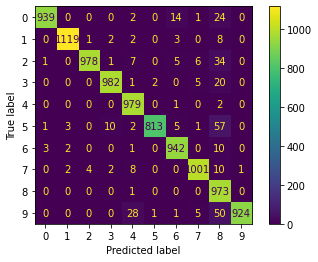

Balanced with Symmetrical Noise
Classification report for classifier <keras.engine.functional.Functional object at 0x7fb4551d9a50>:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.95      0.97      1032
           3       0.98      0.97      0.98      1010
           4       0.95      1.00      0.97       982
           5       1.00      0.91      0.95       892
           6       0.97      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.82      1.00      0.90       974
           9       1.00      0.92      0.96      1009

    accuracy                           0.96     10000
   macro avg       0.97      0.96      0.97     10000
weighted avg       0.97      0.96      0.97     10000




In [12]:
print('Balanced with Symmetrical Noise')

sl_imbalanced4 = SLModel(balanced=True, noise_type='sym', noise_ratio=20)
sl_imbalanced4.pre_process_label()
model3,predicted4 = sl_imbalanced4.train_and_predict()
sl_imbalanced4.display_confusion_matrix(np.argmax(predicted4, axis=1))
print('Balanced with Symmetrical Noise')
print(f"Classification report for classifier {model3}:\n"
    f"{metrics.classification_report(np.argmax(sl_imbalanced4.get_test_label(),axis=1), np.argmax(predicted4, axis=1))}\n")

Balanced with Asymmetrical Noise
(60000, 784)
Print noisy label generation statistics:
Noisy class 0, has 5421 samples.
Noisy class 1, has 6505 samples.
Noisy class 2, has 4337 samples.
Noisy class 3, has 4337 samples.
Noisy class 4, has 5421 samples.
Noisy class 5, has 5421 samples.
Noisy class 6, has 5421 samples.
Noisy class 7, has 5421 samples.
Noisy class 8, has 6505 samples.
Noisy class 9, has 5421 samples.
#correct labels: 0, #incorrect labels: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
108/108 [==============================] - 142s 1s/step - loss: 2.4487 - accuracy: 0.8429
Epoch 2/5
108/108 [==============================] - 138s 1s/step - loss: 1.6455 - accuracy: 0.8861
Epoch 3/5
108/108 [==============================] - 138s 1s/step - loss: 1.5676 - accuracy: 0.8905
Epoch 4/5
108/108 [==============================] - 138s 1s/step - loss: 1.5228 - accuracy: 0.8926
Epoch 5/5
108/108 [==============================] - 139s 1s/step - loss: 1.4871 - accuracy: 0.8951


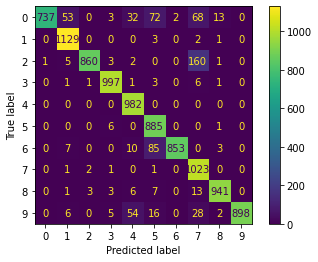

Balanced with Asymmetrical Noise
Classification report for classifier <keras.engine.functional.Functional object at 0x7fb453e73350>:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86       980
           1       0.94      0.99      0.97      1135
           2       0.99      0.83      0.91      1032
           3       0.98      0.99      0.98      1010
           4       0.90      1.00      0.95       982
           5       0.83      0.99      0.90       892
           6       1.00      0.89      0.94       958
           7       0.79      1.00      0.88      1028
           8       0.98      0.97      0.97       974
           9       1.00      0.89      0.94      1009

    accuracy                           0.93     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.94      0.93      0.93     10000




In [13]:
print('Balanced with Asymmetrical Noise')
sl_imbalanced5 = SLModel(balanced=True, noise_type='asym', noise_ratio=20)
sl_imbalanced5.pre_process_label()
model5,predicted5 = sl_imbalanced5.train_and_predict()
sl_imbalanced5.display_confusion_matrix(np.argmax(predicted5, axis=1))
print('Balanced with Asymmetrical Noise')
print(f"Classification report for classifier {model5}:\n"
    f"{metrics.classification_report(np.argmax(sl_imbalanced5.get_test_label(),axis=1), np.argmax(predicted5, axis=1))}\n")

Balanced with No Noise
(60000, 784)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
108/108 [==============================] - 139s 1s/step - loss: 1.0443 - accuracy: 0.9436
Epoch 2/5
108/108 [==============================] - 138s 1s/step - loss: 0.2281 - accuracy: 0.9860
Epoch 3/5
108/108 [==============================] - 138s 1s/step - loss: 0.1565 - accuracy: 0.9907
Epoch 4/5
108/108 [==============================] - 139s 1s/step - loss: 0.1179 - accuracy: 0.9932
Epoch 5/5
108/108 [==============================] - 139s 1s/step - loss: 0.0911 - accuracy: 0.9951


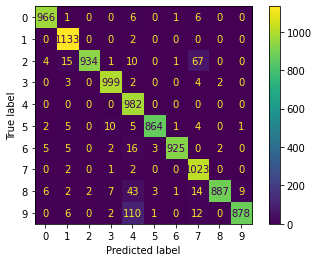

Balanced with No Noise
Classification report for classifier <keras.engine.functional.Functional object at 0x7fb4539ef190>:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.97      1.00      0.98      1135
           2       1.00      0.91      0.95      1032
           3       0.98      0.99      0.98      1010
           4       0.83      1.00      0.91       982
           5       0.99      0.97      0.98       892
           6       1.00      0.97      0.98       958
           7       0.91      1.00      0.95      1028
           8       1.00      0.91      0.95       974
           9       0.99      0.87      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000




In [14]:
print('Balanced with No Noise')
sl_imbalanced3 = SLModel(balanced=True, noise_type='No Noise', noise_ratio=0)
sl_imbalanced3.pre_process_label()
model3,predicted3 = sl_imbalanced3.train_and_predict()
sl_imbalanced3.display_confusion_matrix(np.argmax(predicted3, axis=1))
print('Balanced with No Noise')
print(f"Classification report for classifier {model3}:\n"
    f"{metrics.classification_report(np.argmax(sl_imbalanced3.get_test_label(),axis=1), np.argmax(predicted3, axis=1))}\n")